Computer Vision 

Asma Massad

# Football Player Segmentation and Classification

In this project, you have to use feature engineering and deep learning to provide the following:

▪ Player segmentation.

• Player position: Goalkeeper, Defender, Midfielder or Forward

• Player team

• Player pose and status

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import json
import os
import imantics
import random
import collections

from PIL import Image
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.ndimage import label

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Concatenate, Dropout, Conv2DTranspose, concatenate, AveragePooling2D,Activation,UpSampling2D,BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

%matplotlib inline

<a name='top'></a>
# Table of Contents

* [1. Player Segmentation](#seg)
    * [1.1. Create Multiclass Masks](#mcm)
    * [1.2. UNet Multiclass Segmentation](#unet)
        * [1.2.1. Pre-processing Data](#pre)
        * [1.2.2. UNet Model](#model)
        * [1.2.3. Results](#res)
* [2. Player Role and Team Classification](#rtclass)
    * [2.1 Detecting Field Lines](#lines)
    * [2.2. Players Classification](#class)
* [3. Ball Possession](#pb)
* [4. Players Pose Estimation](#pose)
* [5.Extras](#extra)
* [5. Failed Attempts](#fail)
    * [5.1 Clustering](#clustering)
    * [5.2. Multiclass Masks- Exp1](#exp1)


# Load Images and Masks

In [2]:
'''base_dir = '/kaggle/input/football-player-segmentation'
annote_dir = f'{base_dir}/annotations/instances_default.json'
images_dir = f'{base_dir}/images' '''

annote_dir = 'data/instances_default.json'
images_dir = 'data/images' 

In [3]:
image_size = 512
input_image_size = (1920, 1080)

In [4]:
images_listdir = os.listdir(images_dir)


In [5]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [6]:
annote = json.load(open(annote_dir))

In [7]:
id_to_images = {image['id']:image['file_name'] for image in annote['images']}

In [8]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

In [9]:
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

# Player Segmentaion <a name='seg' href="#top" style="color:#3F497F"> ↑ </a>


## <font color=000000 size = 4> Create Multiclass Masks</font> <a name='mcm' href="#top" style="color:#3F497F"> ↑ </a>

<font color=ff0000, size =3> Separate the players from the background </font>

In [10]:
masked_images = []
for i in range(len(masks)):
    temp_mask = np.copy(masks[i])
    temp_mask = temp_mask.astype(np.uint8) 
    temp_image = np.copy(images[i])
    temp_masked_image = cv2.bitwise_and(temp_image, temp_image, mask=temp_mask)
    masked_images.append(temp_masked_image)

<font color=ff0000, size =3> Separate the players from the background </font>

In [11]:
# Define the target color and threshold for each team
team_a_color = np.array([129, 239, 252]) 
team_b_color = np.array([170, 25, 50]) 
ref_color = np.array([30, 50, 90]) 

# The distance from the center color for the team
distance_a = 60  
distance_b = 60 
distance_ref = 30

# The team color in the multilass mask
class_a_color = 200 
class_b_color = 150
class_ref_color = 40

In [12]:
# Create inverted masks
inverted_masks = []
for i in range(len(masks)):
    temp_inv = masks[i].copy()
    temp_inv =  temp_inv.astype(np.uint8)
    temp_inv[temp_inv == 0 ] = 255
    temp_inv[temp_inv == 1 ] = 0
    inverted_masks.append(temp_inv)

In [13]:

def extractTeamColor(image, target_color, threshold, class_color):
    # Calculate the euclidean distance between each pixel and the target color
    color_distance = np.linalg.norm(image - target_color, axis=2)
    # Create a mask to filter pixels close to the target color
    color_mask = color_distance < threshold

    # Apply the mask to the original image
    extracted_image = np.zeros_like(image)
    extracted_image[color_mask] = image[color_mask]

    # Assign the class color to each channel of the extracted image
    for i in range(extracted_image.shape[2]):
        extracted_image[..., i][extracted_image[..., i] != 0] = class_color

    return extracted_image

In [14]:

def recolorWithMask(image):
    dark_gray = [10, 10, 10]  
    black = [0, 0, 0]  

    # Create a mask for black pixels
    black_pixels_mask = np.all(image == black, axis=2)

    # Create a mask for white pixels
    white_pixels_mask = np.all(image == [255, 255, 255], axis=2)

    # Apply black color to the black pixels
    image[black_pixels_mask] = dark_gray

    # Apply black color to the white pixels
    image[white_pixels_mask] = black

    return image


def recolorFinalClassesMask(image):
    red = [255, 0, 0]  
    blue = [0, 0, 255]  
    green = [0, 255, 0]  
    black = [0, 0, 0]
    yellow = [255, 255, 0]
    
    #-----------------------
    team_a = [200, 200, 200]  
    team_b  =[150, 150, 150]  
    #ref_color = [40, 40, 40]
    #====
    comb1 =[94, 94, 94]
    '''comb2 = [240, 240, 240]
    comb3 = [140, 140, 140]
    comb4 = [136, 136, 136]'''
    
    teamA_pixels_mask = np.all(image == team_a, axis=2)
    teamB_pixels_mask = np.all(image == team_b, axis=2)
    other_pixels_mask = np.all(image == comb1, axis=2)
    #otherMask = np.all((image == comb2) or(image == comb1)  , axis=2)
    
    '''colors = [comb1, comb2, comb3, comb4]
    combined_mask = np.zeros(image.shape[:2], dtype=bool)

    for color in colors:
        mask = np.all(image == color, axis=2)
        combined_mask = np.logical_or(combined_mask, mask)'''
    
    image[teamA_pixels_mask] = blue
    image[teamB_pixels_mask] = red
    #image[ref_pixels_mask] = green
    image[other_pixels_mask] = black

    return image

<font color=ff0000 size=3> Create a colored mask for each team</font>

In [15]:
def createClassMask(image, team_color):
    # Find connected regions
    labels, num_features = label(np.any(image != 0, axis=-1))
    #print('labels', labels[90])
    # Loop through each connected region
    for i in range(1, num_features + 1):
        mask = (labels == i)
        #print('mask', mask.shape)
        # Get the colors in the region
        region_colors = image[mask]
       
        flat_array = region_colors.flatten()
        #print(flat_array)
        vals, counts = np.unique(flat_array, return_counts=True)
        for val, count in zip(vals, counts):
            if val == team_color  and count > 150:
                image[mask] = team_color
            elif (val == team_color  and count < 150) or len(vals) == 1:
                image[mask] = 0

    return image

In [16]:
team_a_masks = []
team_b_masks = []
final_masks = []

for i in range(len(masked_images)):
    extracted_color_A = extractTeamColor(masked_images[i], team_a_color, distance_a, class_a_color)
    new_im_a = extracted_color_A + inverted_masks[i]
    recolor_a = recolorWithMask(new_im_a.copy())
    team_a_mask = createClassMask(recolor_a.copy(),class_a_color)
    team_a_masks.append(team_a_mask)
    #----
    extracted_color_B = extractTeamColor(masked_images[i], team_b_color, distance_b, class_b_color)
    new_im_b = extracted_color_B + inverted_masks[i]
    recolor_b = recolorWithMask(new_im_b.copy())
    team_b_mask = createClassMask(recolor_b.copy(),class_b_color)
    team_b_masks.append(team_b_mask)
     #----
    '''extracted_color_ref = extractTeamColor(masked_images[i], ref_color, distance_ref, class_ref_color)
    new_im_ref = extracted_color_ref + inverted_masks[i]
    recolor_ref = recolorWithMask(new_im_ref.copy())
    team_ref_mask = createClassMask(recolor_ref.copy(), class_ref_color)'''
    
    final_mask = team_a_mask + team_b_mask # + team_ref_mask
    final_masks.append(final_mask)
    

In [17]:
'''extracted_color_c = extractTeamColor(masked_images[0], team_a_color, distance_a, class_a_color)
new_im_c = extracted_color_c + inverted_masks[i]
recolor_c = recolorWithMask(new_im_c.copy())
team_c_mask = createClassMask(recolor_c.copy(),class_a_color)
team_c_mask2 =  createClassMask(team_c_mask.copy(),class_a_color)'''

'extracted_color_c = extractTeamColor(masked_images[0], team_a_color, distance_a, class_a_color)\nnew_im_c = extracted_color_c + inverted_masks[i]\nrecolor_c = recolorWithMask(new_im_c.copy())\nteam_c_mask = createClassMask(recolor_c.copy(),class_a_color)\nteam_c_mask2 =  createClassMask(team_c_mask.copy(),class_a_color)'

In [18]:
for i in range(len(masked_images)):
    final_masks[i] = recolorFinalClassesMask(final_masks[i] )

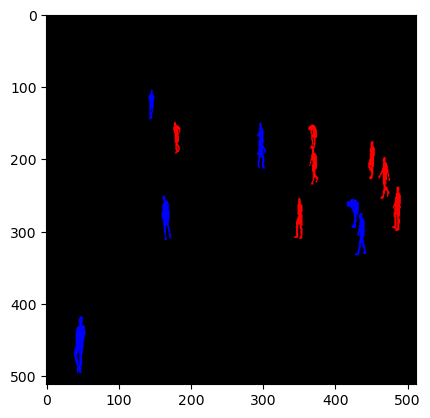

In [19]:
plt.imshow(final_masks[0])

## <font color=000000 size = 4> UNet Multiclass Segmentation</font> <a name='unet' href="#top" style="color:#3F497F"> ↑ </a>

### Preprocessing Data <a name='pre'></a>


In [21]:
def encode_rgb_masks(rgb_masks):
    gray_masks = np.zeros((rgb_masks.shape[0], rgb_masks.shape[1]), dtype=np.uint8)
    
    # Define color-to-intensity mappings for each class
    color_to_intensity = {
        (0, 0, 0): 0,     
        (255, 0, 0): 1,  
        (0, 0, 255): 2    
    }
    for i in range(rgb_masks.shape[0]):
        for j in range(rgb_masks.shape[1]):
            color = tuple(rgb_masks[i, j])
            gray_masks[i, j] = color_to_intensity.get(color, 0)  
    
    return gray_masks

In [22]:
num_classes = 3

In [23]:
# Normalize input images
encoded_masks= []
for i in range(len(final_masks)):
    encoded_masks.append(encode_rgb_masks(final_masks[i]))

In [88]:

input_images = np.array(images)
input_masks = np.array(encoded_masks)

In [90]:
'''
def convert_rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])
'''
input_images = input_images / 255.0


In [101]:

split_ratio = 0.7
split_index = int(len(input_images) * split_ratio)

train_images = input_images[:split_index]
train_masks = input_masks[:split_index]

val_images = input_images[split_index:]
val_masks = input_masks[split_index:]

split_ratio2 = 0.5
split_index2 = int(len(val_images) * split_ratio)

print(split_index2)
validation_images = val_images[:split_index2]
validation_masks = val_masks[:split_index2]

test_images = val_images[split_index2:]
test_masks = val_masks[split_index2:]


107


In [134]:
# Convert grayscale masks to one-hot encoded format
num_classes = 3  
train_masks_encoded = np.zeros((len(train_masks), 512, 512, num_classes), dtype=np.float32)
validation_masks_encoded = np.zeros((len(validation_masks), 512, 512, num_classes), dtype=np.float32)

test_masks_encoded = np.zeros((len(test_masks), 512, 512, num_classes), dtype=np.float32)

for i in range(len(train_masks)):
    train_masks_encoded[i] = tf.one_hot(train_masks[i], num_classes)

for i in range(len(validation_masks)):
    validation_masks_encoded[i] = tf.one_hot(validation_masks[i], num_classes)
    
for i in range(len(test_masks)):
    test_masks_encoded[i] = tf.one_hot(test_masks[i], num_classes)

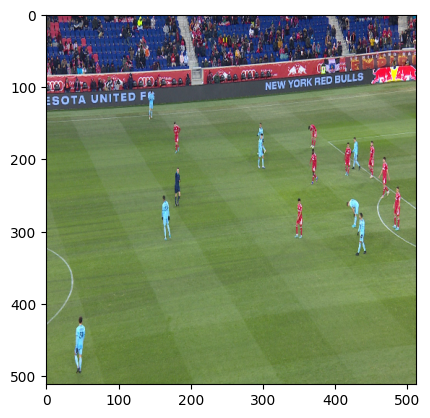

In [91]:
plt.imshow(input_images[0])

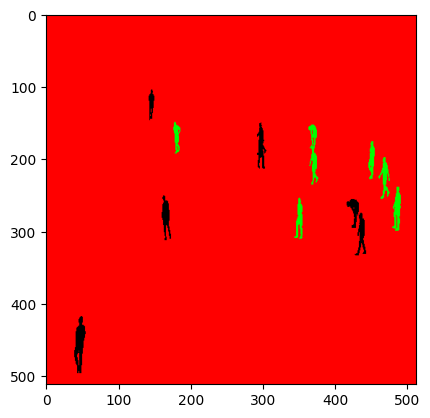

In [104]:
plt.imshow(train_masks_encoded[0])

In [109]:
train_masks_encoded[0].shape

(512, 512, 3)

### UNet Model  <a name='model'></a>

In [105]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def unet_model(input_shape, num_classes=3):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(decode4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [110]:
model = unet_model((512, 512, 3))
max_norm = 1.0

optimizer = tf.keras.optimizers.Adam(clipvalue=max_norm)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
epochs = 5
batch_size = 4
unet_history = model.fit(train_images, train_masks_encoded, validation_data=(validation_images, validation_masks_encoded),
          batch_size=batch_size, epochs=epochs)

Epoch 1/5
90/90 [==============================] - 3740s 42s/step - loss: 0.1846 - accuracy: 0.9685 - val_loss: 0.6710 - val_accuracy: 0.6725
Epoch 2/5
90/90 [==============================] - 3750s 42s/step - loss: 0.0352 - accuracy: 0.9953 - val_loss: 0.0594 - val_accuracy: 0.9927
Epoch 3/5
90/90 [==============================] - 3688s 41s/step - loss: 0.0234 - accuracy: 0.9964 - val_loss: 0.0450 - val_accuracy: 0.9927
Epoch 4/5
90/90 [==============================] - 3683s 41s/step - loss: 0.0179 - accuracy: 0.9970 - val_loss: 0.0222 - val_accuracy: 0.9940
Epoch 5/5
90/90 [==============================] - 3728s 41s/step - loss: 0.0140 - accuracy: 0.9971 - val_loss: 0.0146 - val_accuracy: 0.9972


In [112]:
model.save('unet1-football-asma.h5')

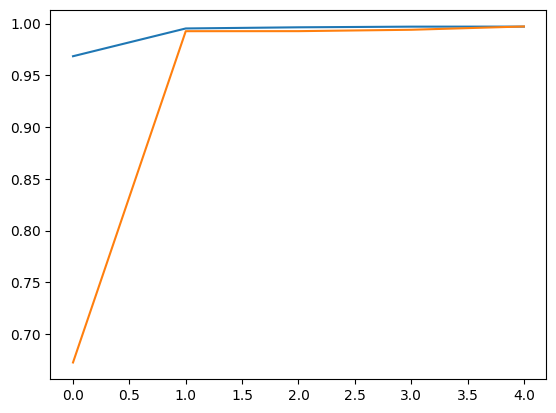

In [113]:
plt.plot(unet_history.history["accuracy"])
plt.plot(unet_history.history["val_accuracy"])

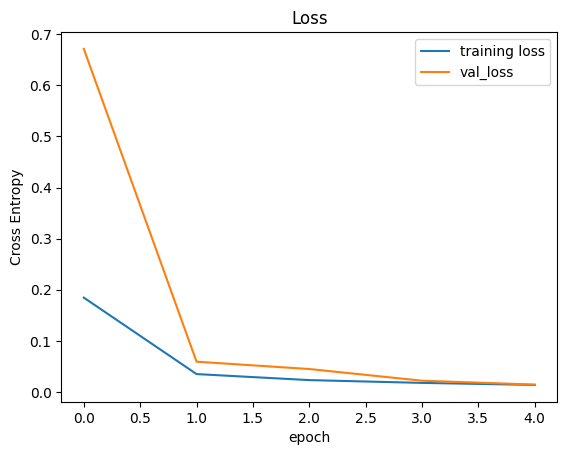

In [114]:
plt.plot(unet_history.history["loss"])
plt.plot(unet_history.history["val_loss"])
plt.ylabel('Cross Entropy')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(('training loss','val_loss'),loc='upper right')

In [155]:

validation_loss, validation_accuracy = model.evaluate(validation_images, validation_masks_encoded, batch_size = 4)


27/27 [==============================] - 312s 12s/step - loss: 0.0146 - accuracy: 0.9972


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks_encoded, batch_size = 4)

In [135]:
train_accuracy = unet_history.history['accuracy'][-1]
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 99.71%
Model Accuracy on the Validation Dataset: 99.72%
Model Accuracy on the Test Dataset: 99.7%


In [ ]:

predicted_mask = model.predict(test_images[0])

In [138]:
unet_predict = model.predict(test_images)

2/2 [==============================] - 127s 40s/step


In [153]:
def show_result(og, unet,  target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net Predicted Mask")
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

### UNet Mask Results <a name='res'></a>


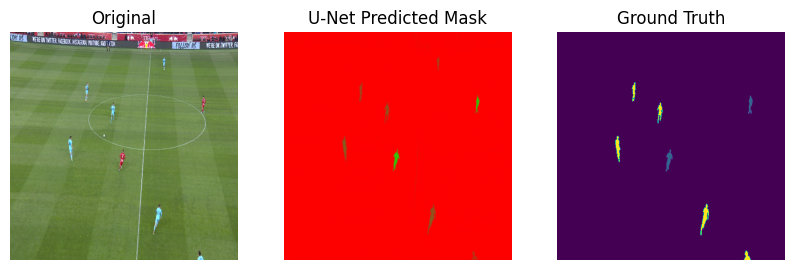

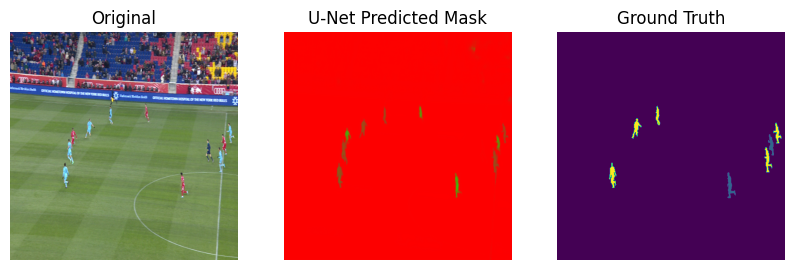

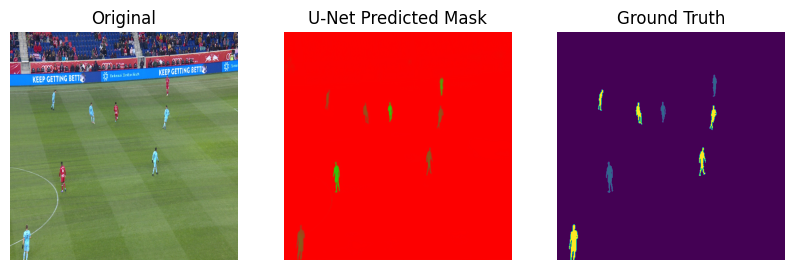

In [154]:
show_test_idx = random.sample(range(47), 3)
for idx in show_test_idx: 
    show_result(test_images[idx], unet_predict[idx], test_masks[idx])

In [156]:
show_test_idx

[3, 18, 13]

# Player Role and Team Classification <a name='rtclass' href="#top" style="color:#3F497F"> ↑ </a>


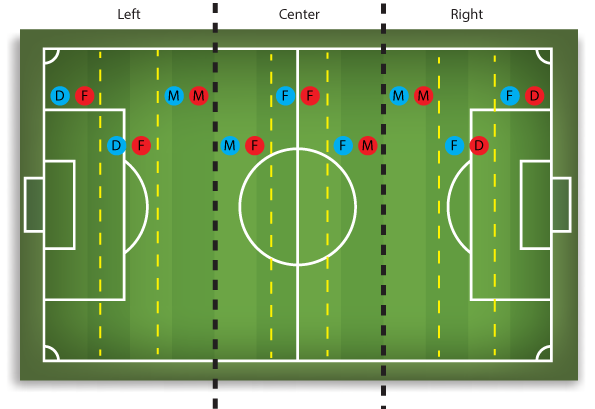

## Field Lines extraction <a name='lines'></a>


In [20]:
def detectLinesCircles(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([90, 255, 255])

    mask = cv2.inRange(hsv, lower_green, upper_green)
    blurred_mask = cv2.GaussianBlur(mask, (5, 5), 0)

    edges = cv2.Canny(mask, 50, 150)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    side_list = []
    for line in lines:
        rho, theta = line[0]

        slope = np.tan(theta)
        
        if slope < -3 and slope > -100:
            side = "Left"
        elif slope > 3 and slope < 100:
            side = "Right"
        elif (slope<0.5 and slope>- 0.5) or slope < -100 or slope > 100:
            side = "Center"
        else:
            if slope<0:
                side = 'Right'
            else:
                side = 'Left'
        #print(side)
        #print('slope ', slope)
        side_list.append(side)
        
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
        
    # Hough circle transform to detect circles 
    '''circles = cv2.HoughCircles(blurred_mask, cv2.HOUGH_GRADIENT, dp=0.1, minDist=150, param1=60, param2=30, minRadius=0, maxRadius=0)

    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)

        filtered_circles = []
        for (x, y, r) in circles:
            if mask[y, x] != 0:
                filtered_circles.append((x, y, r))

        for (x, y, r) in filtered_circles:
            cv2.circle(image, (x, y), r, (0, 255, 0), 2)'''
            
    isCenter = any(item in 'Center' for item in side_list)

    if isCenter:
        field_side = 'Center'
    else:
        sorted_lines = [item for items, c in Counter(side_list).most_common()
                                  for item in [items] * c]
        field_side =  sorted_lines[0]

    return image, field_side


In [21]:
id = 400
test_img = images[id].copy()
test_img, field_side = detectLinesCircles(test_img)

field_side

'Center'

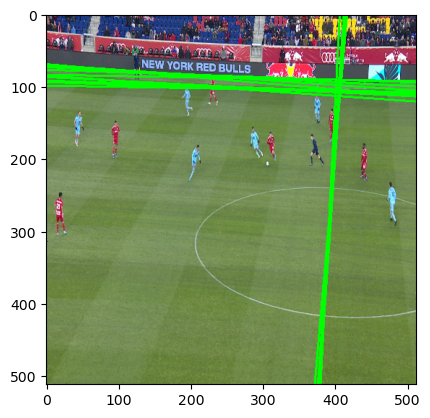

In [22]:
plt.imshow(test_img)

## Players Classification <a name='class' href="#top" style="color:#3F497F"> ↑ </a>

I used the field_side output from the previous step to assign the players roles

In [23]:
def getPlayersRegions(mask):
  
    labels, num_features = label(np.any(mask != 0, axis=-1))
    player_regions = []
    for label_id in range(1, num_features + 1):
        component_mask = (labels == label_id)
        contours, _ = cv2.findContours(component_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bounding_rect = cv2.boundingRect(contours[0])
        player_regions.append(bounding_rect)

    return player_regions

#==========================================================================

def getPlayersRoles(player_regions, field_side, team_a_count, team_b_count):
    roles = []
    team_a = np.full(team_a_count, 'a')
    team_b = np.full(team_b_count, 'b')
    
    teams_tag = np.concatenate([team_a , team_b])
    
    for region , team in zip(player_regions, teams_tag):
        x, y, w, h = region
        center_x = x + w // 2

        # Determine the player's role based on their location on the field side
        if field_side == "Left" :
            if team == 'b':
                if center_x > 340:
                    role = "Midfielder"
                else:
                    role = "Forward"
            else: 
                if center_x <= 340:
                     role = "Defender"
                elif center_x > 340:
                    role = "Midfielder"
                    
        elif field_side == "Right" :
            if team == 'a':
                if center_x < 170:
                    role = "Midfielder"
                else:
                    role = "Forward"
            else: 
                if center_x >= 170:
                     role = "Defender"
                elif center_x < 170:
                    role = "Midfielder"
                    
        elif field_side == "Center":
            if team == 'a':
                if center_x < 170:
                    role = "Midfielder"
                elif  center_x >= 170 :
                    role = "Forward"
            else:
                if center_x < 340:
                    role = "Forward"
                elif  center_x >= 340 :
                    role = "Midfielder"

        roles.append(role)

    return roles

#==========================================================================
def addPlayersRoles(image, regions, roles, team_a_count):
    idx = 0
    for region, role in zip(regions, roles):
        x, y, w, h = region
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2) 
        if idx <= team_a_count:
            team_name = "-A"
        else:
            team_name = "-B"
        idx += 1
        text = getRoleInitial(role)  
        cv2.putText(image, text+team_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)  

#==========================================================================
def getRoleInitial(role):
    if role == "Forward":
        return "F"
    elif role == "Midfielder":
        return "M"
    elif role == "Defender":
        return "D"
    else:
        return "N/A"

In [24]:
def classifyRoleTeam(roles_img, test_img_a_mask, test_img_b_mask, field_side ):

    team_a_regions = getPlayersRegions(test_img_a_mask)  
    team_b_regions = getPlayersRegions(test_img_b_mask)  

    all_regions = team_a_regions + team_b_regions

    team_a_count = len(team_a_regions)
    team_b_count = len(team_b_regions)

    player_roles = getPlayersRoles(all_regions, field_side, team_a_count, team_b_count)
    cv2.putText(roles_img, field_side, (230, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2) 
    addPlayersRoles(roles_img, all_regions, player_roles, team_a_count)
    
    return roles_img

In [23]:

'''print("Team A:")
for i, role in enumerate(player_roles[:len(team_a_regions)]):
    print(f"Player {i+1}: {role}")

print("\nTeam B:")
for i, role in enumerate(player_roles[len(team_a_regions):]):
    print(f"Player {i+1}: {role}")'''

Team A:
Player 1: Forward
Player 2: Forward
Player 3: Midfielder
Player 4: Forward
Player 5: Forward
Player 6: Forward

Team B:
Player 1: Forward
Player 2: Midfielder
Player 3: Forward
Player 4: Forward
Player 5: Midfielder
Player 6: Forward


In [32]:
lines_imgs = []
roles_imgs = []

for i in range(len(masked_images)):
    temp_img = images[i].copy()
    temp_img_a_mask = team_a_masks[i]
    temp_img_mask = team_b_masks[i]
    temp_lines_img, field_side = detectLinesCircles(temp_img)
    temp_img = images[i].copy()
    lines_imgs.append(temp_lines_img)
    temp_roles_img = classifyRoleTeam(temp_img, temp_img_a_mask, temp_img_mask, field_side)
    roles_imgs.append(temp_roles_img)

In [33]:
for i in range(len(images)):
    im = Image.fromarray(lines_imgs[i])
    im.save("FieldLines/field_lines"+str(i)+".jpeg")
    im2 = Image.fromarray(roles_imgs[i])
    im2.save("PlayerRoles/roles"+str(i)+".jpeg")

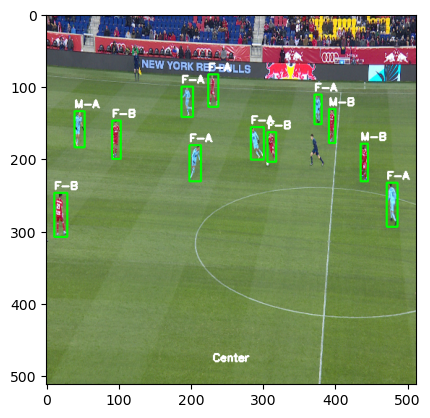

In [34]:
plt.imshow(roles_imgs[400])

# Ball Possession <a name='pb' href="#top" style="color:#3F497F"> ↑ </a>

In [30]:
field_side_list = []

for i in range(len(images)):
    temp_img = images[i].copy()
    temp_img_lines, field_side = detectLinesCircles(temp_img)
    field_side_list.append(field_side)

In [31]:

frequency = collections.Counter(field_side_list)

print(dict(frequency))

{'Right': 99, 'Left': 166, 'Center': 247}


In [32]:
total_attemps = frequency['Right'] + frequency['Left']
team_a_time = frequency['Right']/total_attemps*100
team_b_time = frequency['Left']/total_attemps*100

In [33]:
print('Blue team possession: ', round(team_a_time, 2),'%')
print('Red team possession: ',  round(team_b_time, 2),'%')

Blue team possession:  37.36 %
Red team possession:  62.64 %


# Players Pose Estimation <a name= 'pose' href="#top" style="color:#3F497F"> ↑ </a>


In [34]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [35]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [36]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [37]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [38]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 2, (0,255,0), -1)

In [39]:
cap = cv2.VideoCapture('data/football_game.mp4')

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

'''output_filename = 'football_game_keypoints.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))'''

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize image
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### ===================================================

# Extras <a name='extra' href="#top" style="color:#3F497F"> ↑ </a>


## GoalKeeper A - Mask

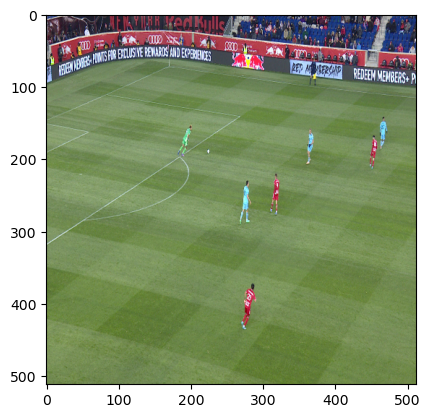

In [37]:
plt.imshow(images[200])

In [38]:
masked_ka = masked_images[200].copy()
mask_ka = masks[200].copy()  

In [39]:
# Define the target color and threshold
goalkeeper1_color = np.array([110, 220, 150])  
threshold_goalkeeper1 = 50  
class_goalkeeper1_color = 160


In [40]:
extracted_image_goalkeeper1 = extractTeamColor(masked_ka, goalkeeper1_color, threshold_goalkeeper1, class_goalkeeper1_color)
newim_gk1 = extracted_image_goalkeeper1 + inverted_masks[200]
redimg_gk1 = recolorWithMask(newim_gk1.copy())
mostfeq_gk1 = createClassMask(redimg_gk1.copy(),class_goalkeeper1_color)

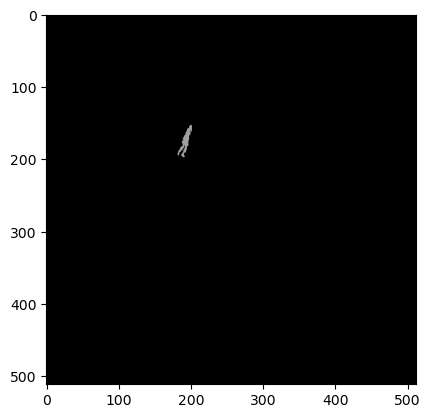

In [41]:
plt.imshow(mostfeq_gk1)

## GoalKeeper B - Mask

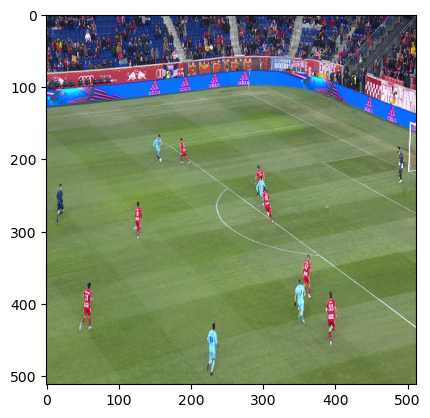

In [42]:
plt.imshow(images[268])

In [43]:
masked_ka = masked_images[268].copy()
mask_ka = masks[268].copy()  

In [44]:
# Define the target color and threshold
goalkeeper2_color = np.array([75, 65, 90])  
threshold_goalkeeper2 = 50  
class_goalkeeper2_color = 80


In [45]:
extracted_image_goalkeeper2 = extractTeamColor(masked_ka, goalkeeper2_color, threshold_goalkeeper2, class_goalkeeper2_color)
newim_gk2= extracted_image_goalkeeper2 + inverted_masks[268]
redimg_gk2 = recolorWithMask(newim_gk2.copy())
mostfeq_gk2 = createClassMask(redimg_gk2.copy(),class_goalkeeper2_color)

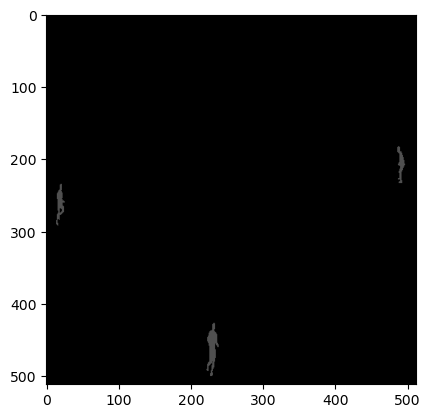

In [46]:
plt.imshow(mostfeq_gk2)

# Failed Attempts <a name='fail' href="#top" style="color:#3F497F"> ↑ </a>

## Clustering <a name='clustering'></a>


In [63]:
def getColorHistogram(image):
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    histogram = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    histogram = cv2.normalize(histogram, histogram).flatten()
    
    return histogram

def classifyObjects(image, mask):
    object_classes = []
    
    mask = np.uint8(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        object_image = image[y:y+h, x:x+w]
        
        histogram = getColorHistogram(object_image)
        
        object_classes.append({"histogram": histogram, "coords": (x, y, x+w, y+h), "label": None})
    
    return object_classes

def drawBBoxes(image, object_classes, class_labels):
    print(len(object_classes))
    for obj in object_classes:
        coords = obj["coords"]
        label = class_labels[obj["label"]]
        
        cv2.rectangle(image, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 2)
        cv2.putText(image, label, (coords[0], coords[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

In [64]:
image2 = images[0].copy()
mask2 = masks[0].copy()

object_classes = classifyObjects(image2, mask2)

class_labels = {0: " A", 1: "B"}

for i, obj in enumerate(object_classes):
    obj["label"] = i % len(class_labels)

output_image = drawBBoxes(image2.copy(), object_classes, class_labels)


14


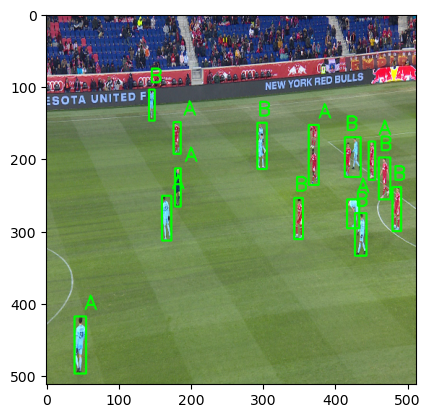

In [65]:
plt.imshow(output_image)

## Multiclass Masks - Experiment 1 <a name='exp1'></a>


In [53]:
def colorMostFrequent(image):
    
    labels, num_features = label(np.any(image != 0, axis=-1))
    for i in range(1, num_features + 1):
        mask = (labels == i)

        region_colors = image[mask]

        if len(region_colors) > 0:
            most_frequent_color = np.bincount(region_colors.reshape(-1, 3).argmax(axis=1)).argmax()
            image[mask] = region_colors[most_frequent_color]

    return image

In [54]:
new_image = colorMostFrequent(np.copy(masked_images[0]))

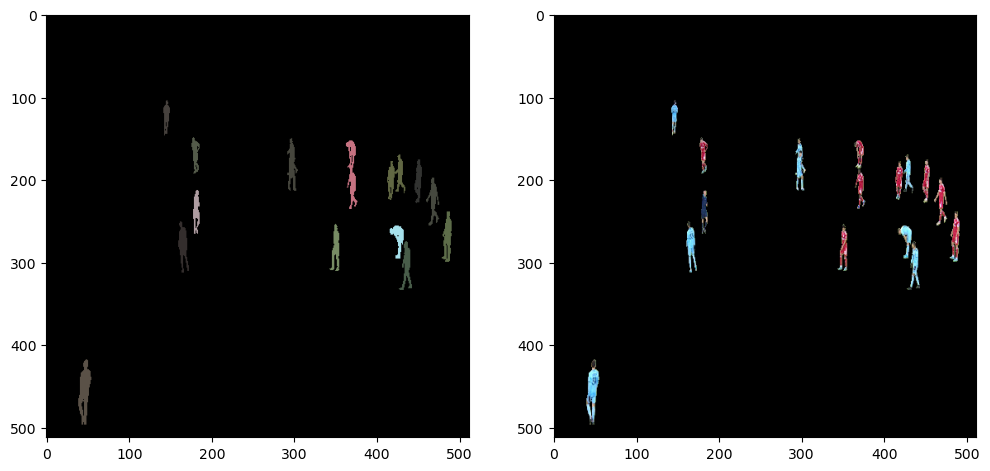

In [57]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(new_image)
ax[1].imshow(masked_images[0])